In [1]:
#au besoin

#%pip install textdistance
#%pip install pandas

# Introduction au projet d'autocorrecteur

Le but de ce projet est simple. Nous allons créer un autocorrecteur qui va corriger les **fautes d'ortographe**, les **fautes de pluralités** et les **fautes de conjugaison** pour des textes en anglais. Le programme va avoir un système de rétroaction où l'utilisateur va pouvoir informer l'AI à propos des corrections proposés afin de savoir si elles sont bonnes ou mauvaises. De plus, si un mot n'est pas dans le dictionnaire, mais qu'il est réutiliser à plusieurs reprises, le programme doit être en mesure de s'adapter et d'accepter ce mot. Ainsi, le programme apprendra les habitudes grammaticales de l'utilisateur et de s'adapter à son écriture.

## Faute d'ortographe

Pour commencer, je vais me charger de trouver un algorithme qui va me permettre de trouver un ortographe erroné et de suggérer des corrections possibles. Je vais utiliser **(1) l'algorithme de distance de Levenshtein**, **(2) la similarité de Jaccard** et un **(3) algorithme de probabilité**.

### (1) L'algorithme de distance de Levenshtein

Pour cet algorithme, l'idée est de trouver le plus petit nombre de modification qu'il faut faire afin que le premier mot soi équivalant au deuxième mot. 

Il y a trois(3) modifications possibles:

1. Remplacer
2. Ajouter
3. Supprimer

Exemple 1 : Textse => Texte, c’est une modification (suppression de «s»)​


Exemple 2 : Gumbo => Gambol, c’est deux modifications («u» pour «a» et ajout de «l»)


Exemple 3 : Mamger => Manger, c’est une modification (remplace «m» par «n»)

Pour expliquer le code ci-dessous, je vais utiliser les mots « love » et « pova » comme exemple.

1) À la premier étape, il faut créer une matrice et l'initialiser à 0. Le mot « love » contient 4 lettres et « pova » contient 4 lettres donc nous aurons une matrice de 5x5 (la première case restera 0).
   
    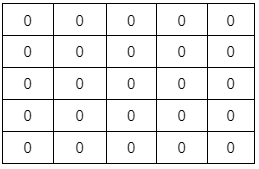
   

2) Maintenant, il faut remplir la première colonne et la première rangée avec des chiffres partant de 0 jusqu'à la taille complète du mot. (Les lettres ne font pas partie de la matrice. Ils sont présents seulement pour l'explication.)

    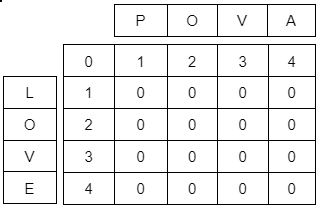

3) Ici, nous allons commencer à comparer les lettres. Voici les étapes:
     1. Si Mot[i] == Mot2[j], alors le coût est de 0
     2. Si Mot[i] != Mot2[j], alors le coût est de 1
  
     3. Entre les trois choix suivants, il faut trouver le plus petit nombre:
        - Matrix[i, j-1] + 1
        - Matrix[i-1, j] + 1
        - Matrix[i-1, j-1] + coût

        Ce nombre va être entreposé dans Matrix[i, j]
     
   
   Pour la première colonne, on va comparer les lettres du mots « LOVE » à la première lettre du mot « POVA ». Voici le résultat :

   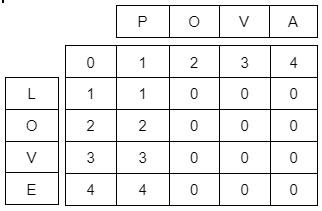

   En premier lieu, on a « L » comparé à « P ». Ces deux lettres sont différents donc le coût == 1.
   - Matrix[i, j-1] + 1 = 2
   - Matrix[i-1, j] + 1 = 2
   - Matrix[i-1, j-1] + coût = 1

  
   D'où Matrix[1, 1] = 1


   En deuxième lieu, on a « O » comparé à « P ». Le coût est 1.
   - Matrix[i, j-1] + 1 = 2
   - Matrix[i-1, j] + 1 = 3
   - Matrix[i-1, j-1] + coût = 1

  
   D'où Matrix[1, 2] = 2

   Il suffit de refaire les mêmes étapes jusqu'à la fin.

   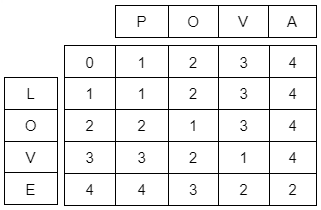


4) Le dernière case nous illustre que la distance est de 2. En effet, on peut voir qu'il faut deux(2) modifications pour que « love » devient « pova ». Il suffit de changer le « l » pour un « p » et changer le « e » pour un « a ».​


In [2]:
def levenshtein_distance(word1, word2):
    # Initialiser la matrice à 0. 
    # 1)
    matrix = [[0] * (len(word2) + 1) for _ in range(len(word1) + 1)]


    # Remplir le premier colonne et la première rangé de la matix
    # 2)
    for i in range(len(word1) + 1):
        matrix[i][0] = i
    for j in range(len(word2) + 1):
        matrix[0][j] = j

    # Calculer la distance de Levenshtein 
    # 3)
    for i in range(1, len(word1) + 1):
        for j in range(1, len(word2) + 1):
            cost = 0 if word1[i - 1] == word2[j - 1] else 1
            matrix[i][j] = min(matrix[i - 1][j] + 1, matrix[i][j - 1] + 1, matrix[i - 1][j - 1] + cost)

    # Retourner la distance (le chiffre dans le coin bas à gauche de la matrix)
    # 4)
    return matrix[len(word1)][len(word2)]

print("La distance de Levenshtein est de: " + str(levenshtein_distance("love", "pova")))

La distance de Levenshtein est de: 2


### (2) Similarité de Jaccard

La similarité de Jaccard est une calculatrice qui peut être importer dans python et permet de calculer la similitude entre deux mots. Pour l'importer il suffit d'ajouter:

*import textdistance*

Cette calculatrice sépare les mots en ensembles. Dans cet exemple, les mots vont être séparés en ensemble de deux(2):

*textdistance.Jaccard(qval=2).distance(mot,mot2)*

Par exemple, pour le mot « apple », les couples « ap », « pp », « pl », « le » vont être créés.

Ces ensembles vont être comparés aux ensembles du deuxième mot. Dans ce cas ci, on va prendre comme exemple « applo » avec les couples « ap », « pp », « pl » et « lo ». 

La formule mathématique est **Jaccard Similarity(A, B) = |A ∩ B| / |A ∪ B|**. En d'autres mots, la similarité de Jaccard est la quantité d'éléments de l'intersection des couples du premier mot et du deuxième mot divisé par le nombre d'éléments de l'union de tous les couples. De plus, toutes les similarités vont être comprisent entre 0 et 1: 0 indiquant aucune similarité et 1 indiquant les couples identiques.

Pour notre exemple:

    |A ∩ B| = 3 (« ap », « pp », « pl »)
    
    |A ∪ B| = 5 (« ap », « pp », « pl », « le », « lo »)

Ce qui donne 0.6

Cepandant, la fonction *textdistance.Jaccard(qval=2).distance(mot,mot2)* trouve la distance entre les deux mots et non la similitude, donc pour trouver la similitude il faut tout simplement faire **1-textdistance.Jaccard(qval=2).distance(mot,mot2)**

In [3]:
import textdistance

sim = [1-(textdistance.Jaccard(qval=2).distance("apple","applo"))]
print("La similitude est de: " + str(sim))

La similitude est de: [0.6]


### (3) Algorithme de probabilité

Pour commencer, il faut aller chercher des données pour que le programme puisse savoir quels sont les mots les plus utilisés. Les meilleures ressources sont les livres gratuits sur internet. À l'aide de ces ressources, nous pouvons étudier la fréquence d'utilisation des mots. Une grosse variété de livres digitals peuvent être trouvés partout sur internet. Pour ce projet, le classique littéraire « Moby dick » est choisi pour son riche vocabulaire varié. Le livre est sauvegardé dans un fichier texte (auto.txt). Le code ci-dessous va lire le fichier et compter la fréquence de chaque mot.



In [4]:
from collections import Counter

import re
import os
mots = []

current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'auto.txt')

#lire le fichier auto.txt
with open(file_path, 'r', encoding='utf-8') as f:
    file_name_data = f.read()
    file_name_data=file_name_data.lower()
    mots = re.findall('\w+', file_name_data)

# V pour vocabulaire
V = set(mots)

#compter la fréquence de chaque mot
mot_freq = {}  
mot_freq = Counter(mots)

#Afficher les 10 mots les plus utilisés
print(mot_freq.most_common()[0:10])

[('the', 14703), ('of', 6742), ('and', 6517), ('a', 4799), ('to', 4707), ('in', 4238), ('that', 3081), ('it', 2534), ('his', 2530), ('i', 2120)]


Par la suite, il faut trouver la probabilité de fréquence de chaque mot. En d'autre mots, c'est la fréquence divisé par le nombre total de mot unique que nous avons. On veut savoir si un mot est utilisé souvent ou non.

In [5]:
probs = {}  

#total de mots
Total = sum(mot_freq.values())   

# pour chaque mot on calcule sa fréquence divisé par le nombre total
for k in mot_freq.keys():
    probs[k] = mot_freq[k]/Total

print(list(probs.items())[:10])

[('the', 0.06602066429280253), ('project', 0.0004086159593718989), ('gutenberg', 0.0004220868151753681), ('ebook', 4.490285267823065e-05), ('of', 0.030273503275663104), ('moby', 0.0004041256741040758), ('dick', 0.0004041256741040758), ('or', 0.003578757358454983), ('whale', 0.00552305087942237), ('by', 0.0054871285972797855)]


## Algorithme final

Maintenant qu'on a trois(3) différentes méthodes pour analyser l'orthographe, il faut les unir tous ensemble pour créer l'algorithme ultime.

In [6]:
import pandas as pd
import numpy as np

def my_autocorrect(mot):
    mot = mot.lower()
    if mot in V:
            return('Le mot est semble être correct')
    else:

        #Probabilité
        df = pd.DataFrame.from_dict(probs, orient='index').reset_index()
        df = df.rename(columns={'index':'Mot', 0:'Prob'})
        
        #similarité de Jaccard
        sim = [1-(textdistance.Jaccard(qval=2).distance(v,mot)) for v in mot_freq.keys()]
        df['Similarity'] = sim 

        #distance de Levenshtein
        distance = [levenshtein_distance(mot, v) for v in mot_freq.keys()] 
        df['distance_Lenv'] = distance 
        
        #Trier les mots par distance, similarité et probabilité
        output = df.sort_values(by=['distance_Lenv','Similarity', 'Prob'], ascending=[True, False, False]).head()
        
        print('Quel mot voulez-vous dire?')
        return(output)

print(my_autocorrect("applo"))

Quel mot voulez-vous dire?
         Mot      Prob  Similarity  distance_Lenv
6595   apple  0.000018    0.600000              1
5173   apply  0.000013    0.600000              1
4366  mapple  0.000040    0.500000              2
5001   appal  0.000013    0.333333              2
4779  appals  0.000009    0.285714              2


# Apprendre des nouveaux mots

Le vocabulaire qui se trouve dans le dictionnaire de l'algorithme est limité donc il faut donner la possibilité d'ajouter des nouveaux mots.

In [7]:
mot = input("Écrivez votre mot: ")

print(my_autocorrect(mot, ))
reponse = input("Entrez un nombre correspondant (0 si le mot n'est pas présent et -1 si le mot est personnalisé):")

if reponse == '-1' :
        with open('newWords.txt', 'a') as file:
            file.write(mot + '\n')

Quel mot voulez-vous dire?
    Mot      Prob  Similarity  distance_Lenv
70    a  0.021549           0              1
459   i  0.009519           0              1
188   s  0.008168           0              1
933   t  0.001392           0              1
815   d  0.000337           0              1


Ce simple code permet d'ouvrir le fichier « newWords.txt » et inserer des nouveaux mots. La prochaine fois on pourra lire les mots du dictionnaire original et les mots du nouveau dictionnaire.

In [8]:
import re
mots = []
with open('auto.txt', 'r', encoding='utf-8') as f:
    file_name_data = f.read()
    file_name_data=file_name_data.lower()
    mots = re.findall(r"[\w']+", file_name_data)

#lire les nouveau mots
with open('newWords.txt', 'r', encoding='utf-8') as f:
    file_name_data = f.read()
    file_name_data=file_name_data.lower()
    mots += re.findall(r"[\w']+", file_name_data)